# ODE/FBA BioSimulators Composite

In [1]:
# change working directory to the vivarium-biosimulators
import sys, os
notebook_path = sys.path[0][:sys.path[0].index('tutorials')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])

In [2]:
# vivarium imports
from vivarium.core.engine import Engine, pf
from vivarium.core.store import Store
from vivarium.core.composer import Composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_simulation_output, plot_variables

# biosimulators imports
from vivarium_biosimulators.library.mappings import remove_multi_update
from biosimulators_cobrapy.data_model import KISAO_ALGORITHMS_PARAMETERS_MAP
from biosimulators_utils.sedml.data_model import ModelLanguage

# turn off warnings
KISAO_ALGORITHMS_PARAMETERS_MAP['KISAO_0000437']['check_status'] = False
import warnings; warnings.filterwarnings('ignore')

In [3]:
# helper functions for notebook
schema_keys = Store.schema_keys

def make_port_printout(ports_schema, depth=0, schema_show=4, filler_size=5):
    print_dict = ''
    filler = filler_size * ' '
    for port, schema in ports_schema.items():
        if isinstance(schema, dict):
            schemavars = list(schema.keys())
            if any(var in schemavars for var in schema_keys):
                print_schema = ''
                for k, v in schema.items():
                    print_schema += f'{(depth+1) * filler} {k}: {v}\n'
                print_dict += f'{depth * filler}{port}:\n{print_schema}'
            else:
                schema_items = schema.items()
                first_schema = dict(list(schema_items)[:schema_show])
                next_print = make_port_printout(first_schema, depth+1)
                print_dict += f'{port}:\n{next_print}\n'
                if len(schema) > schema_show:
                    print_dict += f'{(depth+1) * filler}'
                    print_dict += f'... skipping {len(schema)-schema_show} schema entries ...'
                    print_dict += f'\n\n'
        else:
            print_dict += f'{filler}{schema}\n'
    return print_dict

## BioSimulatorProcess

In [1]:
from vivarium_biosimulators.processes.biosimulator_process import BiosimulatorProcess
print(BiosimulatorProcess.__doc__)

 A Vivarium wrapper for any BioSimulator

    Config:
        - biosimulator_api (str): the name of the imported biosimulator api.
        - model_source (str): a path to the model file.
        - model_language (str): the model language, select from biosimulators_utils.sedml.data_model.ModelLanguage.
        - simulation (str): select from ['uniform_time_course', 'steady_state', 'one_step', 'analysis'].
        - input_ports (dict): a dictionary mapping {'input_port_name': ['list', 'of', 'variables']}.
        - output_ports (dict): a dictionary mapping {'output_port_name': ['list', 'of', 'variables']}.
        - default_input_port_name (str): the default input port for variables not specified by input_ports.
        - default_output_port_name (str): the default output port for variables not specified by output_ports.
        - emit_ports (list): a list of the ports whose values are emitted.
        - algorithm (dict): the kwargs for biosimulators_utils.sedml.data_model.Algorithm.
   

## ODE Process: Biosimulators-Tellurium

### Initialize ODE process
Loads an SBML file for the kinetic model of *E. coli* metabolism reported in:
 * Millard, P., Smallbone, K., & Mendes, P. (2017). Metabolic regulation is sufficient for global and robust coordination of glucose uptake, catabolism, energy production and growth in Escherichia coli. *PLoS computational biology*, 13(2), e1005396.
 * BioModels: https://www.ebi.ac.uk/biomodels/MODEL1505110000

In [5]:
from vivarium_biosimulators.models.model_paths import MILLARD2016_PATH

# declare ode configuration
ode_config = {
    'biosimulator_api': 'biosimulators_tellurium',
    'model_source': MILLARD2016_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'uniform_time_course',
    'algorithm': {
        'kisao_id': 'KISAO_0000019',
    },
    'time_step': 0.1,
}

# make the process
ode_process = BiosimulatorProcess(ode_config)

### Show ports schema
Print some elements of the process's ports schema

In [6]:
ode_ports = ode_process.ports_schema()
ode_printout = make_port_printout(ode_ports)
print(ode_printout)

inputs:
     ACCOA:
           _default: 0.154743005197164
           _updater: accumulate
           _emit: False
     ACO:
           _default: 0.0321498018175313
           _updater: accumulate
           _emit: False
     ACP:
           _default: 0.0143909273594558
           _updater: accumulate
           _emit: False
     AKG:
           _default: 0.59787032384441
           _updater: accumulate
           _emit: False

     ... skipping 81 schema entries ...

outputs:
     time:
           _default: 0.0
           _updater: accumulate
           _emit: True
     ACCOA:
           _default: 0.154743005197164
           _updater: accumulate
           _emit: True
     ACO:
           _default: 0.0321498018175313
           _updater: accumulate
           _emit: True
     ACP:
           _default: 0.0143909273594558
           _updater: accumulate
           _emit: True

     ... skipping 64 schema entries ...




### ODE composite
We aren't wiring the ODE processes with any other process, but using the Composite topology allows us to connect the ODE processes' initial state (in inputs) to its outputs variables. So when it runs, the outputs update the initial state of the next iteration.

In [7]:
ode_composite = Composite({
    'processes': {
        'ode': ode_process
    },
    'topology': {
        'ode': {
            'outputs': ('state',),
            'inputs': ('state',),
        }
    }
})

### ODE topology
Show the topology: both ports connect to the same store.

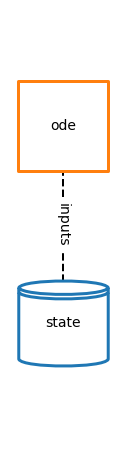

In [8]:
settings = {
    'dashed_edges': True,
    'label_pos': 0.5,
    'buffer': 1.0,
}
tellurium_topology = plot_topology(ode_composite, settings)

### Run a simulation

In [9]:
total_time = 30.

# get initial state from composite
ode_initial_state = ode_composite.initial_state()
ode_initial_state = remove_multi_update(ode_initial_state)

# make an experiment
ode_experiment = Engine(
    processes=ode_composite.processes,
    topology=ode_composite.topology,
    initial_state=ode_initial_state,
)

# run the simulation
ode_experiment.update(total_time)


Simulation ID: 99665b68-2b91-11ec-8e70-acde48001122
Created: 10/12/2021 at 12:21:28
Completed in 1.72 seconds


### Plot output
This shows the dynamics of all the output variables.

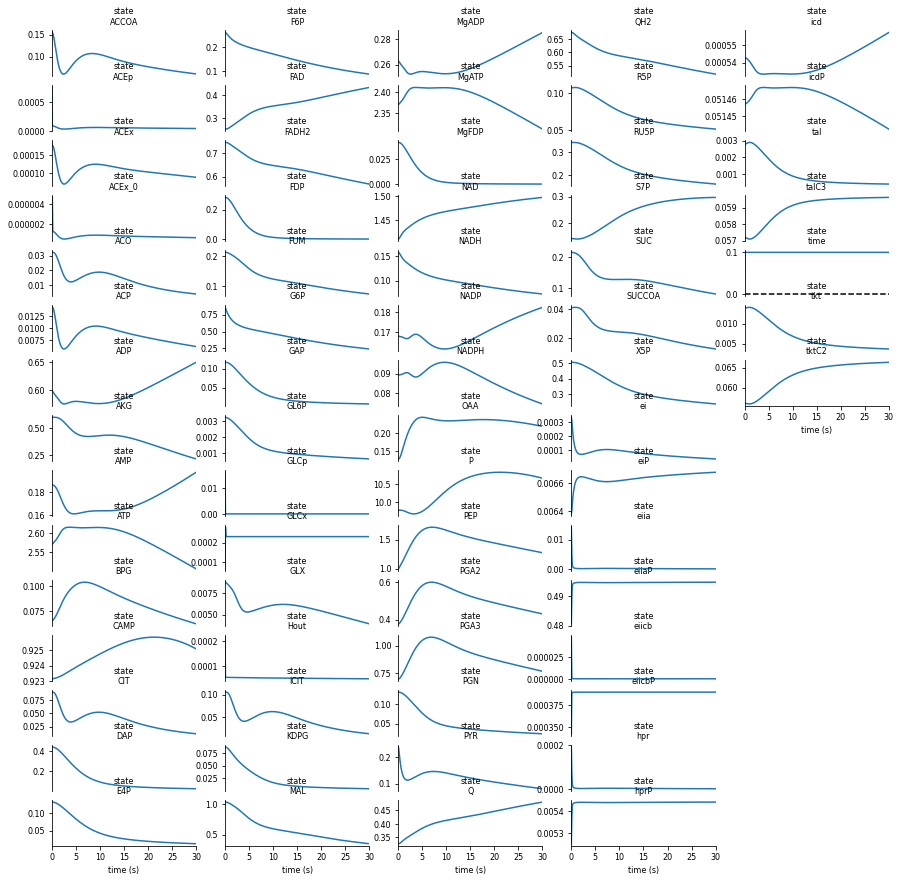

In [10]:
# get the data from the emitter
ode_output = ode_experiment.emitter.get_timeseries()
del ode_output['state']['Pp']  # Why is Pp misbehaving?

# plot
settings = {
    'max_rows': 15,
}
fig = plot_simulation_output(ode_output, settings)

## FBA process: Biosimulators-COBRApy

### Initialize FBA process
Load SBML file for BiGG model iAF1260b:
 * Feist, A. M., Zielinski, D. C., Orth, J. D., Schellenberger, J., Herrgard, M. J., & Palsson, B. Ø. (2010). Model-driven evaluation of the production potential for growth-coupled products of Escherichia coli. *Metabolic engineering*, 12(3), 173-186.
 * BiGG model: http://bigg.ucsd.edu/models/iAF1260b

In [11]:
from vivarium_biosimulators.models.model_paths import BIGG_iAF1260b_PATH

# FBA config
fba_config = {
    'biosimulator_api': 'biosimulators_cobrapy',
    'model_source': BIGG_iAF1260b_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'steady_state',
    'algorithm': {
        'kisao_id': 'KISAO_0000437',
    },
    'emit_ports': ['inputs', 'outputs'],
}

# make the process
fba_process = BiosimulatorProcess(fba_config)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


### Show ports schema
Print some elements of the process's ports schema

In [12]:
fba_ports = fba_process.ports_schema()
fba_printout = make_port_printout(fba_ports)
print(fba_printout)

inputs:
     lower_bound_reaction_R_2AGPGAT161:
           _default: 0.0
           _updater: accumulate
           _emit: True
     upper_bound_reaction_R_2AGPGAT161:
           _default: 999999.0
           _updater: accumulate
           _emit: True
     lower_bound_reaction_R_2AGPGAT180:
           _default: 0.0
           _updater: accumulate
           _emit: True
     upper_bound_reaction_R_2AGPGAT180:
           _default: 999999.0
           _updater: accumulate
           _emit: True

     ... skipping 4772 schema entries ...

outputs:
     obj:
           _default: 3392.5069658081893
           _updater: accumulate
           _emit: True
     R_2AGPGAT161:
           _default: 0.0
           _updater: accumulate
           _emit: True
     R_2AGPGAT180:
           _default: 0.0
           _updater: accumulate
           _emit: True
     R_2AGPGAT181:
           _default: 0.0
           _updater: accumulate
           _emit: True

     ... skipping 2385 schema entries ...




### Timeline process
The `Timeline` process lets you set any state during runtime. Configure it to set some flux bounds.

In [13]:
from vivarium.processes.timeline import TimelineProcess

In [14]:
total_fba_time = 10.

timeline = [
    (4, {('inputs', 'lower_bound_reaction_R_EX_glc__D_e'): -0,
        }),
    (7, {('inputs', 'upper_bound_reaction_R_EX_lac__D_e'): -10,
        }),
    (total_fba_time, {})
]

timeline_process = TimelineProcess({'timeline': timeline})

### FBA/Timeline composite
Wire `timeline` with `fba_process` so that it can change the flux bounds.

In [15]:
# make a composite
fba_composite = Composite({
    'processes': {
        'cobrapy': fba_process,
        'timeline': timeline_process,
    },
    'topology': {
        'cobrapy': {
            'outputs': ('outputs',),
            'inputs': ('inputs',),
        },
        'timeline': {
            'global': ('time',),
            'inputs': ('inputs',),
        },
    }
})

### FBA/Timeline topology
Show the Composite topology. Timeline connects to the input state read by COBRApy, and uses its 'global' port to read the simulation time.

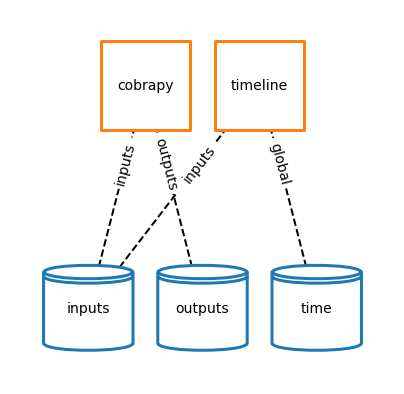

In [16]:
settings = {    
    'dashed_edges': True,
    'label_pos': 0.65,
}
fba_topology = plot_topology(fba_composite, settings)

### Run a simulation

In [17]:
# get initial state from composite
fba_initial_state = fba_composite.initial_state()
fba_initial_state = remove_multi_update(fba_initial_state)

# make an experiment
fba_experiment = Engine(
    processes=fba_composite.processes,
    topology=fba_composite.topology,
    initial_state=fba_initial_state,
)
# run the simulation
fba_experiment.update(total_fba_time)


Simulation ID: c7ad6c96-2b91-11ec-8e70-acde48001122
Created: 10/12/2021 at 12:22:46
Completed in 2.10 seconds


### Plot output
This shows how the perturbation to flux bounds impacts the FBA steady state solution.

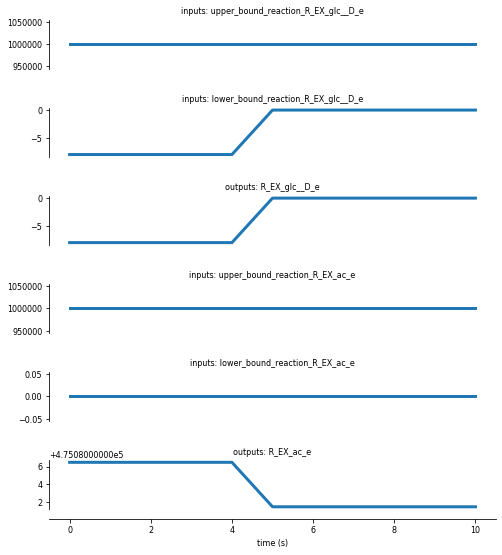

In [18]:
# get the data from emitter
fba_output = fba_experiment.emitter.get_timeseries()

# plot specific output variables
fig = plot_variables(
    fba_output,
    variables=[
        ('inputs', 'upper_bound_reaction_R_EX_glc__D_e'),
        ('inputs', 'lower_bound_reaction_R_EX_glc__D_e'),
        ('outputs', 'R_EX_glc__D_e'),
        ('inputs', 'upper_bound_reaction_R_EX_ac_e'),
        ('inputs', 'lower_bound_reaction_R_EX_ac_e'),
        ('outputs', 'R_EX_ac_e'),
    ],
    row_height=1.5,
)

## Flux Converter Process
The FluxBoundsConverter is a wrapper process that adds a 'bounds' port to an ODE process, allowing it to wire into an FBA process' flux bounds inputs.

In [2]:
from vivarium_biosimulators.processes.flux_bounds import (
    FluxBoundsConverter, get_flux_and_bound_ids)
print(FluxBoundsConverter.__doc__)

A wrapper for an ODE process

    Converts the ODE process's output fluxes to flux bounds inputs for an fba process.

    Parameters:
        * ode_process (BiosimulatorProcess): an initialized ODE BiosimulatorProcess.
        * flux_to_bounds_map (dict): a dictionary that maps the ODE process'
            reactions to flux bounds inputs to the FBA process.
        * flux_unit (str): the units for the ODE reactions (default is mol/L).
        * bounds_unit (str): the units for the FBA bounds (default is mol/L/s).
    Notes:
         * mass and volume should come from a store so it can be updated
    


In [20]:
flux_to_bounds_map = {
    'GLCp': {
        'upper_bound': 'upper_bound_reaction_R_EX_glc__D_e',
        'lower_bound': 'lower_bound_reaction_R_EX_glc__D_e',
        'range': (0.9, 1.1),
    },
    'ACEp': {
        'upper_bound': 'upper_bound_reaction_R_EX_ac_e',
        'lower_bound': 'lower_bound_reaction_R_EX_ac_e',
        'range': (0.9, 1.1),
    },
}
flux_ids, bound_ids = get_flux_and_bound_ids(flux_to_bounds_map)

# make an ode process
ode_config_2 = {
    'output_ports': {'fluxes': flux_ids},
    'emit_ports': ['outputs', 'fluxes'],
    **ode_config,
}
ode_process_2 = BiosimulatorProcess(ode_config_2)
        
# make the flux bounds converter process
flux_bounds_config = {
    'ode_process': ode_process_2,
    'flux_to_bounds_map': flux_to_bounds_map,
    'flux_unit': 'mol/L',
    'bounds_unit': 'mmol/L/s',
}
ode_flux_converter = FluxBoundsConverter(flux_bounds_config)

### Display ports schema

In [21]:
ode_flux_ports = ode_flux_converter.ports_schema()
ode_flux_printout = make_port_printout(ode_flux_ports)
print(ode_flux_printout)

inputs:
     ACCOA:
           _default: 0.154743005197164
           _updater: accumulate
           _emit: False
     ACO:
           _default: 0.0321498018175313
           _updater: accumulate
           _emit: False
     ACP:
           _default: 0.0143909273594558
           _updater: accumulate
           _emit: False
     AKG:
           _default: 0.59787032384441
           _updater: accumulate
           _emit: False

     ... skipping 81 schema entries ...

fluxes:
     GLCp:
           _default: 0.01613347890787672
           _updater: accumulate
           _emit: True
     ACEp:
           _default: 0.000746789775902008
           _updater: accumulate
           _emit: True

outputs:
     time:
           _default: 0.0
           _updater: accumulate
           _emit: True
     ACCOA:
           _default: 0.154743005197164
           _updater: accumulate
           _emit: True
     ACO:
           _default: 0.0321498018175313
           _updater: accumulate
           _emi

### Plot Flux Converter topology

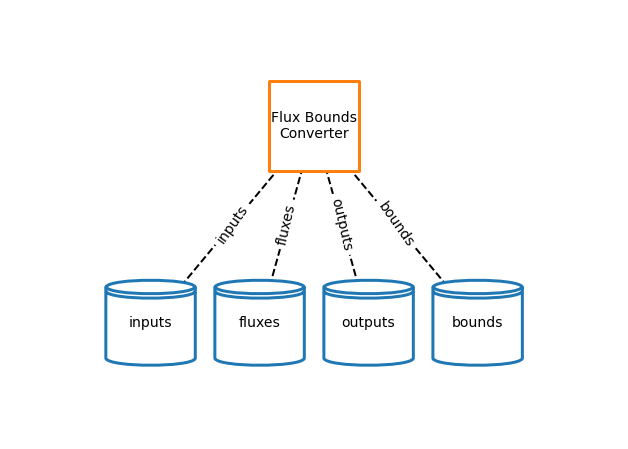

In [22]:
settings = {
    'dashed_edges': True,
    'label_pos': 0.5,
    'buffer': 1.0,
    'node_labels': {
        'FluxBoundsConverter': 'Flux Bounds\nConverter'
    }
}
fba_topology = plot_topology(ode_flux_converter, settings)

## ODE_FBA Composite
ODE_FBA is a Vivarium Composer that is specifically designed to support a BioSimulator ODE and a BioSimulator FBA process in a hybrid simulation. It requires an `ode_config`, an `fba_config`, and a `flux_to_bounds_map` that maps  reaction ids from the ODE process to flux bounds in the FBA process. The composer handles setting up all the ports, and connections, so the user does not need to know about those details.

In [3]:
from vivarium_biosimulators.composites.ode_fba import ODE_FBA
print(ODE_FBA.__doc__)

 Generates an ODE/FBA Composite

    Config:
        - ode_config (dict): configuration for the ode biosimulator.
            Must include values for 'biosimulator_api', 'model_source',
            'simulation', and 'model_language'.
        - fba_config (dict): configuration for the fba biosimulator.
            Must include values for 'biosimulator_api', 'model_source',
            'simulation', and 'model_language'.
        - flux_to_bounds_map (dict): a dictionary that maps the ODE process'
            reactions to flux bounds inputs to the FBA process.
        - default_store (str): The name of a default store, to use if a
            port mapping is not declared by ode_topology or fba_topology.
        - flux_unit (str): The unit of the ode process' flux output.
        - bounds_unit (str): The unit of the fba process' flux bounds input.
    


### Initialize ODE_FBA Composer

In [35]:
from vivarium_biosimulators.models.model_paths import MILLARD2016_PATH, BIGG_iAF1260b_PATH

ode_sync_step = 1.
flux_to_bounds_map = {
    'GLCp': {
        'upper_bound': 'upper_bound_reaction_R_EX_glc__D_e',
        'lower_bound': 'lower_bound_reaction_R_EX_glc__D_e',
        'range': (0.9, 1.1),
    },
    'ACEp': {
        'upper_bound': 'upper_bound_reaction_R_EX_ac_e',
        'lower_bound': 'lower_bound_reaction_R_EX_ac_e',
        'range': (0.9, 1.1),
    },
}

# ODE config
ode_config = {
    'biosimulator_api': 'biosimulators_tellurium',
    'model_source': MILLARD2016_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'uniform_time_course',
    'algorithm': {
        'kisao_id': 'KISAO_0000019',
    },
    'time_step': ode_sync_step,
}
# FBA config
fba_config = {
    'biosimulator_api': 'biosimulators_cobrapy',
    'model_source': BIGG_iAF1260b_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'steady_state',
    'algorithm': {
        'kisao_id': 'KISAO_0000437',
    },
    'emit_ports': ['bounds', 'outputs'],
}
# ODE/FBA composite config
ode_fba_config = {
    'ode_config': ode_config,
    'fba_config': fba_config,
    'flux_to_bounds_map': flux_to_bounds_map,
    'flux_unit': 'mol/L',
    'bounds_unit': 'mmol/g/hr',
    'default_store_name': 'state',
}

# make the ODE_FBA composer
ode_fba_composer = ODE_FBA(ode_fba_config)

In [36]:
# generate a composite
ode_fba_composite = ode_fba_composer.generate()

### ODE/FBA Topology

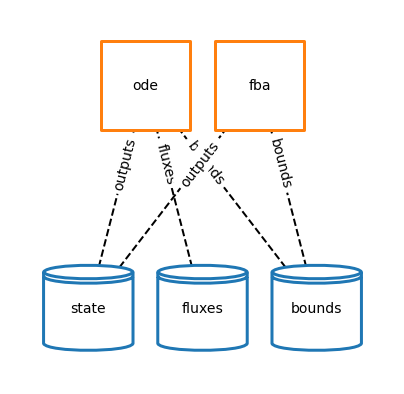

In [37]:
settings = {    
    'dashed_edges': True,
    'label_pos': 0.65,
}
ode_fba_topology = plot_topology(ode_fba_composite, settings)

### Run a simulation

In [38]:
# get initial state from composer
ode_fba_initial_state = ode_fba_composer.initial_state()

# make an experiment
ode_fba_experiment = Engine(
    processes=ode_fba_composite.processes,
    topology=ode_fba_composite.topology,
    initial_state=ode_fba_initial_state,
)
# run the simulation
ode_fba_experiment.update(10.)


Simulation ID: d9f174aa-2b92-11ec-8e70-acde48001122
Created: 10/12/2021 at 12:30:26
Completed in 1.99 seconds


### Plot output

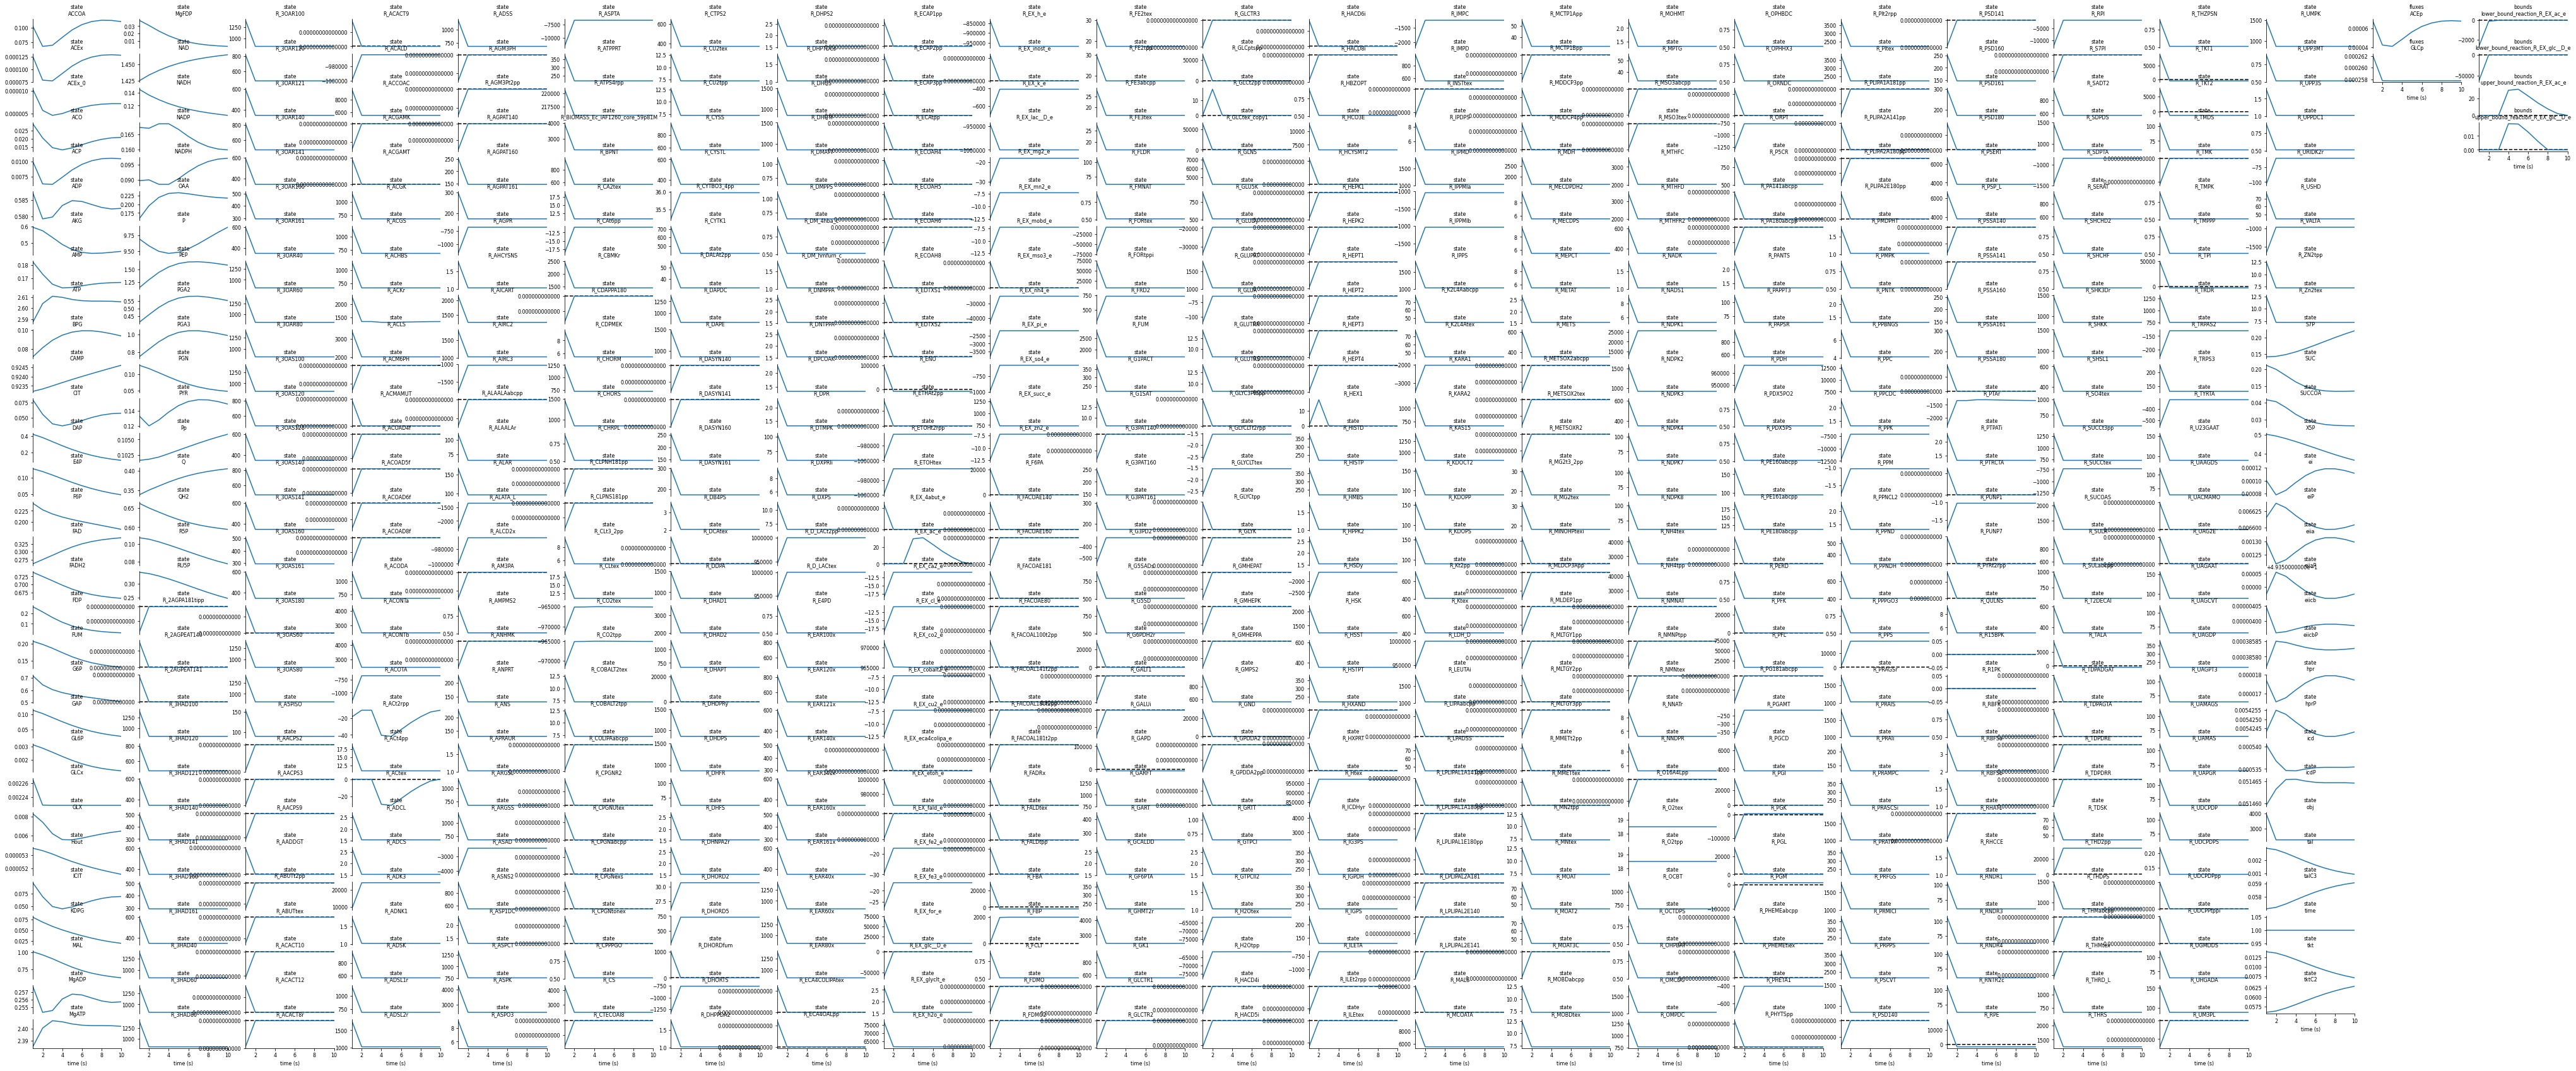

In [39]:
# get the data from emitter
ode_fba_output = ode_fba_experiment.emitter.get_timeseries()

# plot non-static output
fig = plot_simulation_output(
    ode_fba_output,
    {
        'max_rows': 30,
        'remove_first_timestep': True,
        'remove_flat': True,
    },
)

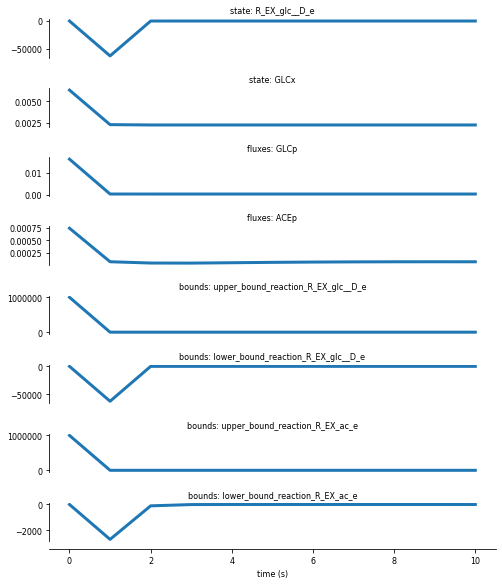

In [43]:
# plot specific output variables
flux_ids, bound_ids = get_flux_and_bound_ids(flux_to_bounds_map)
fluxes = [('fluxes', flux) for flux in flux_ids]
bounds = [('bounds', bound) for bound in bound_ids]
fig = plot_variables(
    ode_fba_output,
    variables=[
        ('state', 'R_EX_glc__D_e'),
        ('state', 'GLCx'),
    ] + fluxes + bounds,
)